# Sentiment Analysis

This notebook converts raw Reddit data into valuable sentiment scores.

Some parts of the code in this notebook were generated with the assistance of ChatGPT, an AI language model developed by OpenAI. However, every single line of code was manually reviewed by the author of this notebook.

### Table of Content

* [1. Check the csv-files with reddit data for errors](#chapter1)
* [2. Concat the csv-files with reddit data to one dataframe](#chapter2)
* [3. Preprocessing](#chapter3)
* [4. Sentiment Analysis](#chapter4)
* [5. Preparation for Machine Learning](#chapter5)
* [6. Visualisation](#chapter6)

## 1. Check the csv-files with reddit data for errors <a class='anchor' id='chapter1'></a>
The following function checks all csv-files in a specific folder for errors and returns a summary of any issues found.

In [1]:
import os
import pandas as pd
import numpy as np

def check_csvs_for_errors(folder_path):
    # Dictionary to hold error messages
    errors = {}
    
    # Helper function to compare types
    def is_type_compatible(value, expected_type):
        if isinstance(value, expected_type):
            return True
        if expected_type is np.int64 and isinstance(value, int):
            return True
        if expected_type is np.float64 and isinstance(value, float):
            return True
        if expected_type is pd.Timestamp and isinstance(value, (pd.Timestamp, str)):
            return True
        return False

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            file_errors = []
            
            try:
                # Attempt to read the csv-file with semicolon delimiter
                df = pd.read_csv(file_path, delimiter=';')
                
                # Check for missing values
                if df.isnull().values.any():
                    for col in df.columns:
                        for idx, is_missing in df[col].isnull().items():
                            if is_missing:
                                file_errors.append(f"Missing value in column '{col}', row {idx + 1}")
                
                # Check for inconsistent data types in each column
                for col in df.columns:
                    if df[col].dropna().empty:
                        continue  # skip empty columns
                    try:
                        # Try to convert to datetime if applicable
                        df[col] = pd.to_datetime(df[col], errors='raise', format='%Y-%m-%dT%H:%M:%S')
                        expected_type = pd.Timestamp
                    except ValueError:
                        expected_type = type(df[col].dropna().iloc[0])
                    
                    for idx, val in df[col].items():
                        if pd.notna(val) and not is_type_compatible(val, expected_type):
                            file_errors.append(f"Inconsistent data type in column '{col}', row {idx + 1}: expected {expected_type}, got {type(val)}")
            
            except Exception as e:
                # Record any error that occurs during reading
                file_errors.append(str(e))
            
            if file_errors:
                errors[filename] = file_errors
    
    return errors

The second function applies the check_csvs_for_errors function to each folder whose name starts with "reddit_" in a specific parent folder. Therefore, we do not need to manually apply the previous function for each folder.

In [2]:
def check_all_reddit_folders(parent_folder_path):
    # List to hold error details
    error_details = []
    
    # Iterate over all folders in the parent folder
    for folder_name in os.listdir(parent_folder_path):
        if folder_name.startswith('reddit_'):
            folder_path = os.path.join(parent_folder_path, folder_name)
            if os.path.isdir(folder_path):
                # Check for errors in the current folder
                folder_errors = check_csvs_for_errors(folder_path)
                for file, errors in folder_errors.items():
                    for error in errors:
                        error_details.append({
                            'Folder': folder_name,
                            'File': file,
                            'Error': error
                        })
    
    # Convert the list of error details to a DataFrame
    error_df = pd.DataFrame(error_details)
    
    return error_df

We apply the function to the 'data' folder to check all csv-files with reddit data for errors.

In [3]:
# Search for errors in all csv files than contain reddit data
parent_folder_path = './data'
all_errors = check_all_reddit_folders(parent_folder_path)
all_errors

,Folder,File,Error
0,reddit_goog,reddit_wallstreetbets_goog_posts.csv,"Missing value in column 'Content', row 56"
1,reddit_amzn,reddit_wallstreetbets_amzn_posts.csv,"Missing value in column 'Content', row 14"
2,reddit_amzn,reddit_wallstreetbets_amzn_posts.csv,"Missing value in column 'Content', row 43"
3,reddit_meta,reddit_wallstreetbets_meta_posts.csv,"Missing value in column 'Content', row 34"
4,reddit_amd,reddit_wallstreetbets_amd_posts.csv,"Missing value in column 'Content', row 79"
5,reddit_adbe,reddit_wallstreetbets_adbe_posts.csv,"Missing value in column 'Content', row 13"


We will drop rows that contain missing values later.

## 2. Concat the csv-files with reddit data to one dataframe <a class='anchor' id='chapter2'></a>
The following function converts all csv-files in all folders that start with 'reddit_' in a specific parent folder to pandas dataframes. It creates a dataframe for each folder with the folder's name.

In [4]:
import os
import pandas as pd

def concat_csvs_in_folders(parent_folder_path):
    # Dictionary to hold the resulting DataFrames
    dfs = {}
    
    # Iterate over all folders in the parent folder
    for folder_name in os.listdir(parent_folder_path):
        if folder_name.startswith('reddit_'):
            folder_path = os.path.join(parent_folder_path, folder_name)
            if os.path.isdir(folder_path):
                # List to hold individual dataframes
                df_list = []
                
                # Iterate over all files in the folder
                for filename in os.listdir(folder_path):
                    if filename.endswith('.csv'):
                        file_path = os.path.join(folder_path, filename)
                        try:
                            df = pd.read_csv(file_path, delimiter=';')
                            df_list.append(df)
                        except pd.errors.ParserError as e:
                            print(f"Error parsing {file_path}: {e}")
                        except Exception as e:
                            print(f"Unexpected error with {file_path}: {e}")
                
                if df_list:
                    # Concatenate all dataframes in the list
                    concatenated_df = pd.concat(df_list, ignore_index=True)
                    # Add the concatenated dataframe to the dictionary
                    dfs[folder_name] = concatenated_df
                else:
                    print(f"No valid CSV files found in {folder_path}")
                
    return dfs

# Convert all csv files with reddit data to dataframes
parent_folder_path = './data'
result_dfs = concat_csvs_in_folders(parent_folder_path)

No valid CSV files found in ./data/reddit_ea


In [5]:
# Example
result_dfs['reddit_aapl']

,Post Title,Post URL,Content,Post Score,Post Date
0,"Warren Buffett Sells Apple Shares, Buys Lots O...",https://www.reddit.com/r/investing/comments/1a...,[https://www.ft.com/content/780409aa-8285-4c58...,481,2024-02-16T11:26:01
1,how does apple make money from apple cash and ...,https://www.reddit.com/r/investing/comments/13...,"Obviously, the main benefit of these two servi...",117,2023-05-17T05:06:20
2,Is it Time to Bail on Apple?,https://www.reddit.com/r/investing/comments/1c...,Was wondering what the sub thinks about holdin...,0,2024-04-16T16:26:20
3,Future of my Apple stock?,https://www.reddit.com/r/investing/comments/1b...,"Hi, a small investor here. I bought a few Appl...",0,2024-03-08T16:10:42
4,I have 15% of my portfolio tied up in two stoc...,https://www.reddit.com/r/investing/comments/14...,I know for some people that would be a large p...,204,2023-07-04T08:48:51
...,...,...,...,...,...
624,My fancy crayons have told me that Apple broke...,https://www.reddit.com/r/wallstreetbets/commen...,&#x200B: https://preview.redd.it/7rahff7zbplc...,8,2024-03-01T11:42:56
625,Why AAPL TSLA will keep climbing 🥦🥦🥦🥦🥦,https://www.reddit.com/r/wallstreetbets/commen...,Apple way too fuckin cheap Everything is so ...,358,2023-07-01T16:49:31
626,Apple’s WWDC event is coming up. Puts or Calls...,https://www.reddit.com/r/wallstreetbets/commen...,"So, Apple’s WWDC will be debuting on June 5th ...",19,2023-05-31T00:43:06
627,Potential DIS play from the Apple feature?,https://www.reddit.com/r/wallstreetbets/commen...,I saw a post the other day about some analyst ...,0,2023-06-12T15:21:16


In [6]:
# Find the stocks with the reddit posts
def print_dataframe_info(result_dfs):
    import pandas as pd

    # Creating a list to store the dataframe names and their row counts
    df_info = []

    for name, df in result_dfs.items():
        if isinstance(df, pd.DataFrame):
            df_info.append((name, df.shape[0]))
        else:
            print(f"Warning: Element {name} is not a DataFrame and will be skipped.")

    # Converting the list to a DataFrame for easier sorting and displaying
    df_info_df = pd.DataFrame(df_info, columns=['DataFrame', 'Number of Rows'])

    # Sorting the DataFrame by 'Number of Rows' in descending order
    df_info_df = df_info_df.sort_values(by='Number of Rows', ascending=False).reset_index(drop=True)

    # Printing the DataFrame
    print(df_info_df)

print_dataframe_info(result_dfs)

      DataFrame  Number of Rows
0   reddit_goog             687
1   reddit_aapl             629
2   reddit_amzn             597
3   reddit_nvda             535
4   reddit_msft             520
5   reddit_tsla             483
6   reddit_meta             410
7    reddit_amd             394
8   reddit_intc             312
9   reddit_nflx             206
10  reddit_pypl             192
11  reddit_uber             150
12  reddit_orcl              82
13  reddit_adbe              81
14   reddit_ibm              76
15   reddit_crm              67
16  reddit_csco              62
17  reddit_crwd              41
18  reddit_qcom              31
19   reddit_ttd              25


Next, we want to concat all dataframes in the result_dfs dictionary into one dataframe and add a "stock" column to know which stock a reddit post represents.

In [7]:
def concat_all_dfs_with_stock_column(result_dfs):
    all_dfs = []
    
    for folder_name, df in result_dfs.items():
        stock_name = folder_name.replace('reddit_', '')
        df['stock'] = stock_name
        all_dfs.append(df)
    
    concatenated_df = pd.concat(all_dfs, ignore_index=True)
    return concatenated_df

reddit_df = concat_all_dfs_with_stock_column(result_dfs)
reddit_df

,Post Title,Post URL,Content,Post Score,Post Date,stock
0,Trade Desk (TTD) is worth buying on declines,https://www.reddit.com/r/investing/comments/1b...,**Positives** * Trade Desk $TTD is growin...,5,2024-03-22T15:42:56,ttd
1,Goldman Sachs has told their clients to get ou...,https://www.reddit.com/r/investing/comments/1a...,A couple of key quotes from the paper from the...,378,2024-02-12T12:27:47,ttd
2,Is there any site that lists how to access for...,https://www.reddit.com/r/investing/comments/1c...,There's a few assets I think could appreciate....,0,2024-04-22T18:21:03,ttd
3,Setting up a corp for trading?,https://www.reddit.com/r/investing/comments/16...,Little background: My spouse has pretty string...,0,2023-09-17T17:37:07,ttd
4,I closed my Ameritrade trading account but I s...,https://www.reddit.com/r/investing/comments/15...,As most of you know Ameritrade has been sold t...,0,2023-08-03T04:17:46,ttd
...,...,...,...,...,...,...
5575,Palantir Releases its AI Sports Analysis Platf...,https://www.reddit.com/r/wallstreetbets/commen...,This is the last post I’ll be making about Pal...,46,2024-02-07T22:44:47,adbe
5576,How to profit off Applechia?,https://www.reddit.com/r/wallstreetbets/commen...,"How do you do, fellow investors and investards...",0,2023-06-02T22:08:00,adbe
5577,$HOOD - A New Bull Market Beneficary,https://www.reddit.com/r/wallstreetbets/commen...,"Hello everyone, It's been quite some time si...",210,2023-06-16T02:11:57,adbe
5578,"To Sail Forbidden Seas, $HOOD - Q2/23 ER Guess",https://www.reddit.com/r/wallstreetbets/commen...,"Hello everyone, I mentioned in some comments ...",102,2023-07-19T07:40:03,adbe


## 3. Preprocessing <a class='anchor' id='chapter3'></a>

We preprocesses the dataframe by performing the following operations:
1. Remove the column "Post URL".
2. Merge the column "Post Title" into "Content" with the format "Title: Content".
3. Delete the time in "Post Date" and converts the remaining date to a pandas date.
4. Remove duplicate rows.
5. Remove rows with missing values.
6. Remove URLs from the "Content" column.
7. Scale the "Post Score" for each stock so that the highest value for each stock is 1.
8. Create a new column 'Content Preprocessed' for the manipulated content.
9. Convert everthing in 'Content Preprocessed' and the column names of the df to lowercase.

In [8]:
#!python3 -m spacy download en_core_web_sm

In [9]:
import re
import spacy

# Load Spacy's English language model
nlp = spacy.load('en_core_web_sm')

def preprocess(df):
    # Create a copy of the dataframe
    df_copy = df.copy()

    # Remove the "Post URL" column
    df_copy = df_copy.drop(columns=['Post URL'])
    
    # Merge "Post Title" into "Content"
    df_copy['Content'] = df_copy['Post Title'] + ": " + df_copy['Content']
    
    # Remove the "Post Title" column
    df_copy = df_copy.drop(columns=['Post Title'])
    
    # Delete the time in "Post Date" and convert to pandas datetime
    df_copy['Post Date'] = pd.to_datetime(df_copy['Post Date']).dt.date
    
    # Remove duplicate rows
    df_copy = df_copy.drop_duplicates()
    
    # Remove rows with missing values
    df_copy = df_copy.dropna()
    
    # Remove URLs from the "Content" column
    df_copy['Content'] = df_copy['Content'].apply(lambda x: re.sub(r'http\S+', '', x))

    # Scale "Post Score" for each stock
    df_copy['Post Score'] = df_copy.groupby('stock')['Post Score'].transform(lambda x: x / x.max())

    # Create a new column "Content Preprocessed"
    df_copy['Content Preprocessed'] = df_copy['Content'].copy()

    # Convert the content to lowercase
    df_copy['Content Preprocessed'] = df_copy['Content Preprocessed'].str.lower()

    # Convert the column names of the df to lowercase
    df_copy.columns = df_copy.columns.str.lower()

    # Use Spacy to remove stop words and lemmatize the text
    def preprocess_spacy(text):
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc if not token.is_stop]
        return ' '.join(tokens)

    # Apply the function
    df_copy['content preprocessed'] = df_copy['content preprocessed'].apply(preprocess_spacy)
    
    return df_copy

reddit_df_preprocessed = preprocess(reddit_df)
reddit_df_preprocessed

,content,post score,post date,stock,content preprocessed
0,Trade Desk (TTD) is worth buying on declines: ...,0.002111,2024-03-22,ttd,trade desk ( ttd ) worth buy decline : * * pos...
1,Goldman Sachs has told their clients to get ou...,0.159561,2024-02-12,ttd,goldman sach tell client parabolic tech . ( en...
2,Is there any site that lists how to access for...,0.0,2024-04-22,ttd,site list access foreign stock exchange americ...
3,Setting up a corp for trading?: Little backgro...,0.0,2023-09-17,ttd,set corp trading ? : little background : spous...
4,I closed my Ameritrade trading account but I s...,0.0,2023-08-03,ttd,close ameritrade trading account ira . sure wa...
...,...,...,...,...,...
5575,Palantir Releases its AI Sports Analysis Platf...,0.058154,2024-02-07,adbe,palantir release ai sport analysis platform de...
5576,"How to profit off Applechia?: How do you do, f...",0.0,2023-06-02,adbe,"profit applechia ? : , fellow investor investa..."
5577,$HOOD - A New Bull Market Beneficary: Hello e...,0.265487,2023-06-16,adbe,$ hood - new bull market beneficary : hello ...
5578,"To Sail Forbidden Seas, $HOOD - Q2/23 ER Guess...",0.128951,2023-07-19,adbe,"sail forbid sea , $ hood - q2/23 er guess : he..."


## 4. Sentiment Analysis <a class='anchor' id='chapter4'></a>

First, we create two smaller dataframes for testing: one with example sentences and one with the first 4 rows of the original data.

In [10]:
# Testing df with example sentences
data = {'content preprocessed': ["I love this product!", "This is the worst experience ever.", "Apple's stock price will fall", "NVDA will go to the moon", "Apple was sued...", 
    "i predict that this company will make a lot of sales in the upcoming year"]}
example_sentences = pd.DataFrame(data)

# Testing df with the original data
reddit_df_preprocessed_test = reddit_df_preprocessed[0:4]
reddit_df_preprocessed_test

,content,post score,post date,stock,content preprocessed
0,Trade Desk (TTD) is worth buying on declines: ...,0.002111,2024-03-22,ttd,trade desk ( ttd ) worth buy decline : * * pos...
1,Goldman Sachs has told their clients to get ou...,0.159561,2024-02-12,ttd,goldman sach tell client parabolic tech . ( en...
2,Is there any site that lists how to access for...,0.0,2024-04-22,ttd,site list access foreign stock exchange americ...
3,Setting up a corp for trading?: Little backgro...,0.0,2023-09-17,ttd,set corp trading ? : little background : spous...


The next function leverages two sentiment analysis tools: TextBlob and a pre-trained DistilRoBERTa model fine-tuned for financial news sentiment analysis. Here's a detailed breakdown of what the function does:

1. **TextBlob Sentiment Analysis**:
    - **Polarity**: The function `get_textblob_polarity` calculates the polarity of the text using TextBlob. Polarity ranges from -1 (negative) to 1 (positive), indicating the sentiment's negativity or positivity.
    - **Subjectivity**: The function `get_textblob_subjectivity` calculates the subjectivity of the text using TextBlob. Subjectivity ranges from 0 (objective) to 1 (subjective), indicating the degree of personal opinion or factual information in the text.

2. **DistilRoBERTa Sentiment Analysis**:
    - **Sentiment Label and Score**: The function `get_distilroberta_sentiment_features` uses a pre-trained DistilRoBERTa model to classify the sentiment of the text and obtain a confidence score. It maps the sentiment labels ('positive', 'neutral', 'negative') to numerical values (1, 0, -1) and returns both the label and the score.

3. **Applying Sentiment Functions**:
    - The function applies the TextBlob polarity and subjectivity functions to the 'content preprocessed' column of the DataFrame.
    - It also applies the DistilRoBERTa sentiment function to the same column, adding the results as new columns ('distilroberta label' and 'distilroberta score').

4. **Return Processed DataFrame**: Finally, the function returns the modified DataFrame containing the original data along with the new sentiment analysis columns.

By incorporating both TextBlob and a specialized DistilRoBERTa model, this function provides a comprehensive sentiment analysis, capturing both general sentiment (via TextBlob) and domain-specific sentiment (via DistilRoBERTa).

In [11]:
from textblob import TextBlob
from transformers import pipeline

# Initialize the sentiment-analysis pipeline with the fine-tuned distilroberta model from https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis
pipe = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

def analyse_sentiment(df):
    # Make a copy of the input dataframe
    df_copy = df.copy()

    # Function to get the sentiment polarity with textblob
    def get_textblob_polarity(text):
        return TextBlob(text).sentiment.polarity

    # Function to get the sentiment subjectivity with textblob
    def get_textblob_subjectivity(text):
        return TextBlob(text).sentiment.subjectivity

    # Function to get the sentiment label/score from distilroberta
    def get_distilroberta_sentiment_features(text):
        result = pipe(text)[0]  # extract the result from the list of dictionaries
        label = result['label']
        score = result['score']

        # Convert label to a numerical value
        if label == 'positive':
            label_value = 1
        elif label == 'neutral':
            label_value = 0
        elif label == 'negative':
            label_value = -1

        return pd.Series([label_value, score])
    
    # Apply the textblob functions
    df_copy['textblob polarity'] = df_copy['content preprocessed'].apply(get_textblob_polarity)
    df_copy['textblob subjectivity'] = df_copy['content preprocessed'].apply(get_textblob_subjectivity)

    # Apply the distilroberta function
    df_copy[['distilroberta label', 'distilroberta score']] = df_copy['content preprocessed'].apply(get_distilroberta_sentiment_features)
    
    return df_copy

# Apply the analyse_sentiment function to the preprocessed dataframe
reddit_df_sentiment = analyse_sentiment(reddit_df_preprocessed)
reddit_df_sentiment

2024-08-01 16:07:38.020682: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-08-01 16:07:38.020706: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-01 16:07:38.020718: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-01 16:07:38.021230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-01 16:07:38.021387: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you a

,content,post score,post date,stock,content preprocessed,textblob polarity,textblob subjectivity,distilroberta label,distilroberta score
0,Trade Desk (TTD) is worth buying on declines: ...,0.002111,2024-03-22,ttd,trade desk ( ttd ) worth buy decline : * * pos...,0.178691,0.589301,-1.0,0.996473
1,Goldman Sachs has told their clients to get ou...,0.159561,2024-02-12,ttd,goldman sach tell client parabolic tech . ( en...,0.066667,0.833333,1.0,0.994136
2,Is there any site that lists how to access for...,0.0,2024-04-22,ttd,site list access foreign stock exchange americ...,-0.020833,0.104167,0.0,0.999886
3,Setting up a corp for trading?: Little backgro...,0.0,2023-09-17,ttd,set corp trading ? : little background : spous...,-0.067424,0.571212,0.0,0.999866
4,I closed my Ameritrade trading account but I s...,0.0,2023-08-03,ttd,close ameritrade trading account ira . sure wa...,0.378182,0.658148,0.0,0.999369
...,...,...,...,...,...,...,...,...,...
5575,Palantir Releases its AI Sports Analysis Platf...,0.058154,2024-02-07,adbe,palantir release ai sport analysis platform de...,-0.008367,0.511107,1.0,0.949444
5576,"How to profit off Applechia?: How do you do, f...",0.0,2023-06-02,adbe,"profit applechia ? : , fellow investor investa...",0.006426,0.524582,0.0,0.999676
5577,$HOOD - A New Bull Market Beneficary: Hello e...,0.265487,2023-06-16,adbe,$ hood - new bull market beneficary : hello ...,0.116994,0.468325,0.0,0.997843
5578,"To Sail Forbidden Seas, $HOOD - Q2/23 ER Guess...",0.128951,2023-07-19,adbe,"sail forbid sea , $ hood - q2/23 er guess : he...",0.063213,0.539237,0.0,0.997338


## 5. Preparation for Machine Learning <a class='anchor' id='chapter5'></a>

In the next step, we need to prepare the dataframe for the upcoming machine learning part. The function `transform_df` drops the content columns, reorders the columns and sorts the dataframe by stock and post date.

In [12]:
def transform_df(df):
    # Make a copy of the input dataframe
    df_copy = df.copy()

    # Drop the specified columns
    df_copy = df_copy.drop(columns=['content', 'content preprocessed'])
    
    # Reorder the columns
    df_copy = df_copy[['stock', 'post date', 'post score', 'textblob polarity', 'textblob subjectivity', 'distilroberta label', 'distilroberta score']]
    
    # Sort by 'stock' and 'post date'
    df_copy = df_copy.sort_values(by=['stock', 'post date'])

    # Adjust DistilRoBERTa score based on its label
    df_copy.loc[:, 'adjusted_distilroberta_score'] = df_copy['distilroberta label'] * df_copy['distilroberta score']
    
    return df_copy

reddit_sentiment_transformed = transform_df(reddit_df_sentiment)
reddit_sentiment_transformed

,stock,post date,post score,textblob polarity,textblob subjectivity,distilroberta label,distilroberta score,adjusted_distilroberta_score
1976,aapl,2023-05-06,0.001251,0.062957,0.375081,0.0,0.996256,0.000000
2073,aapl,2023-05-06,0.0,0.050827,0.379600,1.0,0.998496,0.998496
2369,aapl,2023-05-06,0.026095,0.376623,0.637103,0.0,0.994433,0.000000
2176,aapl,2023-05-07,0.046828,0.278333,0.613333,1.0,0.999334,0.999334
1815,aapl,2023-05-08,0.016086,0.650000,0.625000,0.0,0.783868,0.000000
...,...,...,...,...,...,...,...,...
1092,uber,2024-05-14,0.008097,0.059118,0.433766,1.0,0.563117,0.563117
1093,uber,2024-05-15,0.002167,0.096548,0.380741,0.0,0.971001,0.000000
1154,uber,2024-05-15,0.0,0.130357,0.510714,1.0,0.998841,0.998841
1163,uber,2024-05-18,0.006956,0.244146,0.693526,1.0,0.965972,0.965972


The data is now ready to be used for machine learning and will therefore be saved to a csv file. 

In [13]:
# Export the data to a csv file
#reddit_sentiment_transformed.to_csv('./data/reddit_sentiment.csv', index=False)

## 6. Visualisation <a class='anchor' id='chapter6'></a>

The `visualize_sentiment` function is designed to create a clear and informative visualization comparing the sentiment analysis results from TextBlob and a pre-trained DistilRoBERTa model. The function performs the following steps:

1. **Data Filtering and Copy**: It filters the input DataFrame for a specified stock ticker and creates a copy of this filtered data to avoid modifying the original DataFrame.

2. **Date Conversion**: Converts the 'post date' column to datetime format to ensure correct plotting on the x-axis.

3. **Sentiment Score Adjustment**: Computes an adjusted DistilRoBERTa score by multiplying the sentiment label with its score, allowing for the sentiment direction (positive or negative) to be reflected in the score.

4. **Sorting Data**: Sorts the DataFrame by 'post date' to ensure the time series plot is accurate.

5. **Rolling Mean Calculation**: Calculates a 7-day rolling mean for both the TextBlob polarity and the adjusted DistilRoBERTa score. This smoothing technique helps to visualize trends more clearly by reducing short-term fluctuations.

6. **Plot Creation**:
   - **TextBlob Polarity**: Plots the rolling mean of TextBlob polarity with blue circles connected by a solid line.
   - **DistilRoBERTa Adjusted Score**: Plots the rolling mean of the adjusted DistilRoBERTa score with red crosses connected by a dashed line.
   - Both plots include labels, a title, and a legend for clarity.
   
7. **Grid and Display**: Adds a grid for better readability and displays the plot.

This visualization helps to compare the sentiment trends identified by TextBlob and DistilRoBERTa, providing insights into how sentiment evolves over time for a specific stock. The use of rolling means and clear plot styling enhances readability, making it easier to identify patterns and differences between the two sentiment analysis methods.

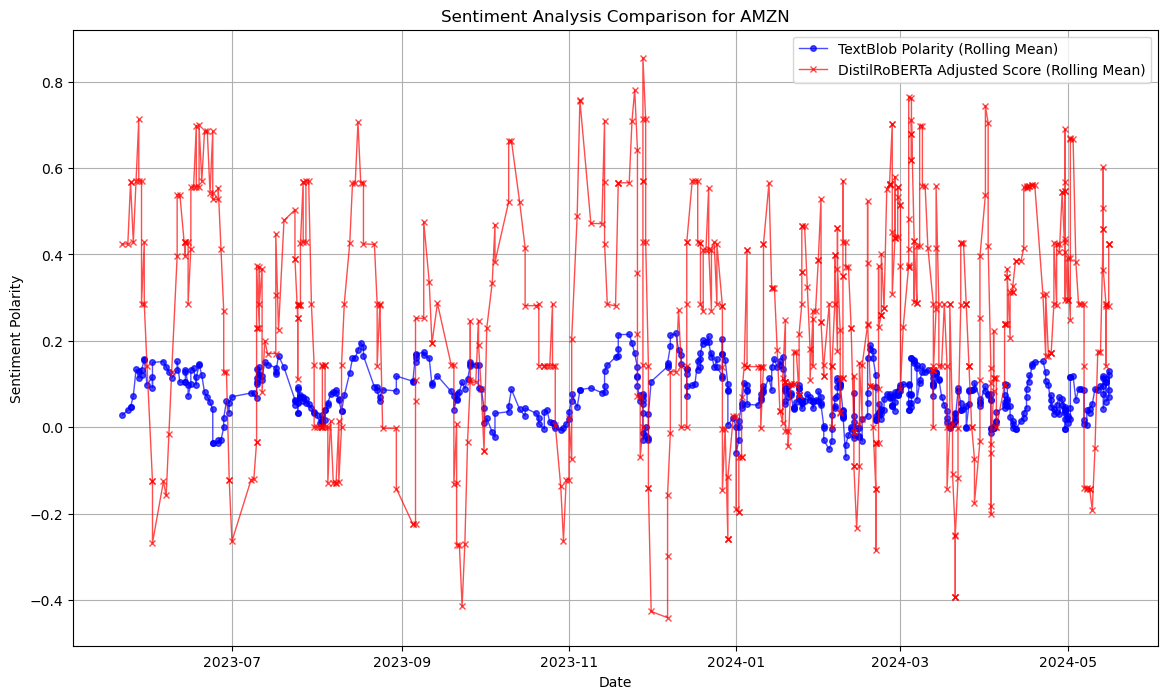

In [20]:
import matplotlib.pyplot as plt

def visualize_sentiment(df, stock):
    # Filter the dataframe for the specified stock
    df_stock = df[df['stock'] == stock].copy()
    
    # Convert 'post date' to datetime
    df_stock.loc[:, 'post date'] = pd.to_datetime(df_stock['post date'])
    
    # Adjust DistilRoBERTa score based on its label
    df_stock.loc[:, 'adjusted_distilroberta_score'] = df_stock['distilroberta label'] * df_stock['distilroberta score']
    
    # Sort by 'post date'
    df_stock = df_stock.sort_values(by='post date')
    
    # Calculate rolling mean for smoothing
    df_stock['textblob polarity rolling'] = df_stock['textblob polarity'].rolling(window=7).mean()
    df_stock['adjusted distilroberta score rolling'] = df_stock['adjusted_distilroberta_score'].rolling(window=7).mean()
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Plot TextBlob polarity
    plt.plot(df_stock['post date'], df_stock['textblob polarity rolling'], label='TextBlob Polarity (Rolling Mean)', marker='o', linestyle='-', color='b', alpha=0.7, linewidth=1, markersize=4)
    
    # Plot adjusted DistilRoBERTa score
    plt.plot(df_stock['post date'], df_stock['adjusted distilroberta score rolling'], label='DistilRoBERTa Adjusted Score (Rolling Mean)', marker='x', linestyle='-', color='r', alpha=0.7, linewidth=1, markersize=4)
    
    # Set the title and labels
    plt.title(f'Sentiment Analysis Comparison for {stock.upper()}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Polarity')
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.show()

# Example plot with 'amzn' (Amazon)
visualize_sentiment(reddit_sentiment_transformed, 'amzn')